<a href="https://colab.research.google.com/github/ellaclauz/EXAMPLES_KNEARESTNEIGHBORS/blob/main/CKD_FOR_KNN_EXAMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nearest Neighbors

We’re going to work with a data set that was collected to help doctors diagnose chronic kidney disease (CKD). Each row in the data set represents a single patient who was treated in the past and whose diagnosis is known. For each patient, we have a bunch of measurements from a blood test. We’d like to find which measurements are most useful for diagnosing CKD, and develop a way to classify future patients as “has CKD” or “doesn’t have CKD” based on their blood test results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ckd.csv to ckd.csv


In [5]:
data = pd.read_csv('ckd.csv')
data.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,1
1,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,...,29,12100,3.7,yes,yes,no,poor,no,yes,1
2,63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,...,32,4500,3.8,yes,yes,no,poor,yes,no,1
3,68,80,1.010,3,2,normal,abnormal,present,present,157,...,16,11000,2.6,yes,yes,yes,poor,yes,no,1
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,1


# Data Cleaning

In [6]:
data = data.rename(columns={"Blood Glucose Random": "Glucose"})

In [7]:
data.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,1
1,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,...,29,12100,3.7,yes,yes,no,poor,no,yes,1
2,63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,...,32,4500,3.8,yes,yes,no,poor,yes,no,1
3,68,80,1.010,3,2,normal,abnormal,present,present,157,...,16,11000,2.6,yes,yes,yes,poor,yes,no,1
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,1


# Exploratory Data Analysis

In [12]:
data.shape

(158, 25)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      158 non-null    int64  
 1   Blood Pressure           158 non-null    int64  
 2   Specific Gravity         158 non-null    float64
 3   Albumin                  158 non-null    int64  
 4   Sugar                    158 non-null    int64  
 5   Red Blood Cells          158 non-null    object 
 6   Pus Cell                 158 non-null    object 
 7   Pus Cell clumps          158 non-null    object 
 8   Bacteria                 158 non-null    object 
 9   Glucose                  158 non-null    int64  
 10  Blood Urea               158 non-null    int64  
 11  Serum Creatinine         158 non-null    float64
 12  Sodium                   158 non-null    int64  
 13  Potassium                158 non-null    float64
 14  Hemoglobin               1

In [9]:
data['Class'].value_counts(normalize=True)

0    0.727848
1    0.272152
Name: Class, dtype: float64

Let’s look at two columns in particular: the hemoglobin level (in the patient’s blood), and the blood glucose level (at a random time in the day; without fasting specially for the blood test).

We’ll draw a scatter plot to visualize the relation between the two variables.

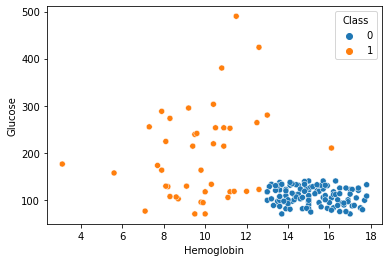

In [10]:
sn.scatterplot(x="Hemoglobin", y="Glucose", data=data, hue="Class")
plt.show()

Suppose Alice is a new patient who is not in the data set. If I tell you Alice’s hemoglobin level and blood glucose level, could you predict whether she has CKD? It sure looks like it! You can see a very clear pattern here: points in the lower-right tend to represent people who don’t have CKD, and the rest tend to be folks with CKD. To a human, the pattern is obvious. But how can we program a computer to automatically detect patterns such as this one?

## Nearest-Neighbor Classifier

If we have Alice’s hemoglobin and glucose numbers, we can put her somewhere on this scatterplot; the hemoglobin is her x-coordinate, and the glucose is her y-coordinate. Now, to predict whether she has CKD or not, we find the nearest point in the scatterplot and check whether it is blue or gold; we predict that Alice should receive the same diagnosis as that patient.

In other words, to classify Alice as CKD or not, we find the patient in the training set who is “nearest” to Alice, and then use that patient’s diagnosis as our prediction for Alice. The intuition is that if two points are near each other in the scatterplot, then the corresponding measurements are pretty similar, so we might expect them to receive the same diagnosis (more likely than not). We don’t know Alice’s diagnosis, but we do know the diagnosis of all the patients in the training set, so we find the patient in the training set who is most similar to Alice, and use that patient’s diagnosis to predict Alice’s diagnosis.

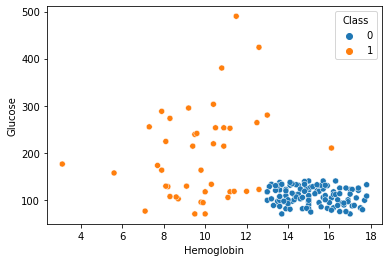

In [11]:
sn.scatterplot(x="Hemoglobin", y="Glucose", data=data, hue="Class")
plt.show()

The nearest neighbor classifier would work like this:
1. Find the point in the training set that is nearest to the new point.
2. If that nearest point is a “CKD” point, classify the new point as “CKD”. If the nearest point is a “not CKD” point, classify the new point as “not CKD”.

The scatterplot suggests that this nearest neighbor classifier should be pretty accurate. Points in the lower-right will tend to receive a “no CKD” diagnosis, as their nearest neighbor will be a blue point. The rest of the points will tend to receive a “CKD” diagnosis, as their nearest neighbor will be a orange point. So the nearest neighbor strategy seems to capture our intuition pretty well, for this example.

## k-nearest neighbor classifier

However, the separation between the two classes won’t always be quite so clean. For instance, suppose that instead of hemoglobin levels we were to look at white blood cell count. Look at what happens:

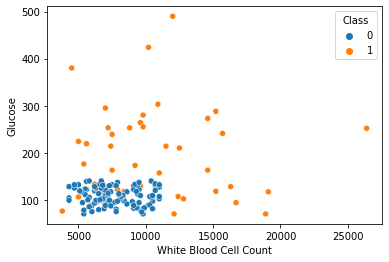

In [13]:
sn.scatterplot(x="White Blood Cell Count", y="Glucose", data=data, hue="Class")
plt.show()

 As the scatterplot above indicates, sometimes people with CKD have glucose and white blood cell levels that look identical to those of someone without CKD, so any classifier is inevitably going to make the wrong prediction for them.

Can we automate this on a computer? Well, the nearest neighbor classifier would be a reasonable choice here too. Take a minute and think it through: how will its predictions compare to those from the intuitive strategy above? When will they differ?

Its predictions will be pretty similar to our intuitive strategy, but occasionally it will make a different prediction. In particular, if Alice’s blood test results happen to put her right near one of the blue dots in the lower-left, the intuitive strategy would predict ‘not CKD’, whereas the nearest neighbor classifier will predict ‘CKD’.

There is a simple generalization of the nearest neighbor classifier that fixes this anomaly. It is called the k-nearest neighbor classifier. To predict Alice’s diagnosis, rather than looking at just the one neighbor closest to her, we can look at the 3 points that are closest to her, and use the diagnosis for each of those 3 points to predict Alice’s diagnosis. In particular, we’ll use the majority value among those 3 diagnoses as our prediction for Alice’s diagnosis. Of course, there’s nothing special about the number 3: we could use 4, or 5, or more. (It’s often convenient to pick an odd number, so that we don’t have to deal with ties.) In general, we pick a number
, and our predicted diagnosis for Alice is based on the patients in the training set who are closest to Alice. Intuitively, these are the patients whose blood test results were most similar to Alice, so it seems reasonable to use their diagnoses to predict Alice’s diagnosis.

## Training and Testing Split

### Isolate the `y` variable.
This is also known as the outcome variable / the target variable / the dependent variable. Essentially, this is the variable that you want to predict.

In [14]:
y=data["Class"]

In [15]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64

### Isolate the `X` variables.
Also known as the features / the independent variables. Essentially, these are the variables that you want to use to predict `y`.

In [17]:
X= data.drop(columns="Class")

In [18]:
X.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,...,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,11.2,32,6700,3.9,yes,no,no,poor,yes,yes
1,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,...,9.5,29,12100,3.7,yes,yes,no,poor,no,yes
2,63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,...,10.8,32,4500,3.8,yes,yes,no,poor,yes,no
3,68,80,1.010,3,2,normal,abnormal,present,present,157,...,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      158 non-null    int64  
 1   Blood Pressure           158 non-null    int64  
 2   Specific Gravity         158 non-null    float64
 3   Albumin                  158 non-null    int64  
 4   Sugar                    158 non-null    int64  
 5   Red Blood Cells          158 non-null    object 
 6   Pus Cell                 158 non-null    object 
 7   Pus Cell clumps          158 non-null    object 
 8   Bacteria                 158 non-null    object 
 9   Glucose                  158 non-null    int64  
 10  Blood Urea               158 non-null    int64  
 11  Serum Creatinine         158 non-null    float64
 12  Sodium                   158 non-null    int64  
 13  Potassium                158 non-null    float64
 14  Hemoglobin               1

In [20]:
X.columns

Index(['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
       'Red Blood Cells', 'Pus Cell', 'Pus Cell clumps', 'Bacteria', 'Glucose',
       'Blood Urea', 'Serum Creatinine', 'Sodium', 'Potassium', 'Hemoglobin',
       'Packed Cell Volume', 'White Blood Cell Count', 'Red Blood Cell Count',
       'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
       'Appetite', 'Pedal Edema', 'Anemia'],
      dtype='object')

In [21]:
X = X[["Age", "Blood Pressure", "Specific Gravity", "Albumin", "Sugar", "Glucose", "Blood Urea", 'Serum Creatinine', 'Sodium', 'Potassium', 'Hemoglobin',
       'Packed Cell Volume', 'White Blood Cell Count', 'Red Blood Cell Count']]

In [22]:
X.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count
0,48,70,1.005,4,0,117,56,3.8,111,2.5,11.2,32,6700,3.9
1,53,90,1.020,2,0,70,107,7.2,114,3.7,9.5,29,12100,3.7
2,63,70,1.010,3,0,380,60,2.7,131,4.2,10.8,32,4500,3.8
3,68,80,1.010,3,2,157,90,4.1,130,6.4,5.6,16,11000,2.6
4,61,80,1.015,2,0,173,148,3.9,135,5.2,7.7,24,9200,3.2


### Split `X` and `y` into training and testing sets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

Check what the training and testing sets look like.

In [24]:
X_train.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count
27,21,90,1.010,4,0,107,40,1.7,125,3.5,8.3,23,12400,3.9
111,43,60,1.025,0,0,108,25,1.0,144,5.0,17.8,43,7200,5.5
110,22,60,1.025,0,0,97,18,1.2,138,4.3,13.5,42,7900,6.4
85,43,80,1.025,0,0,81,46,0.6,135,4.9,13.9,48,6900,4.9
18,52,90,1.015,4,3,224,166,5.6,133,47.0,8.1,23,5000,2.9


In [25]:
X_test.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count
7,73,70,1.005,0,0,70,32,0.9,125,4.0,10.0,29,18900,3.5
44,23,80,1.025,0,0,70,36,1.0,150,4.6,17.0,52,9800,5.0
113,29,80,1.020,0,0,83,49,0.9,139,3.3,17.5,40,9900,4.7
120,47,60,1.020,0,0,117,22,1.2,138,3.5,13.0,45,5200,5.6
63,30,80,1.025,0,0,96,25,0.5,144,4.8,13.8,42,9000,4.5


In [26]:
y_train.head()

27     1
111    0
110    0
85     0
18     1
Name: Class, dtype: int64

In [27]:
y_test.head()

7      1
44     0
113    0
120    0
63     0
Name: Class, dtype: int64

Check the shapes of the training and testing sets.

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118, 14), (40, 14), (118,), (40,))

## Implement K-NN

### Create a `KNeighborsClassifier` object.

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)

### Fit the `KNeighborsClassifier` to the training data.

In [30]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Use the fitted `KNeighborsClassifier` to predict on the training set.

In [31]:
preds_train = knn.predict(X_train)

Check data types of the predictions and the true values for training set.

In [32]:
type(preds_train), type(y_train)

(numpy.ndarray, pandas.core.series.Series)

How to compare predictions to true values for training set:

In [33]:
preds_train == y_train

27      True
111     True
110     True
85      True
18     False
       ...  
9       True
103     True
67      True
117     True
47      True
Name: Class, Length: 118, dtype: bool

[Approach A] Compute accuracy of predictions for training set:

In [34]:
sum(preds_train == y_train) / len(preds_train)

0.864406779661017

[Approach B] Compute accuracy of predictions for training set:

In [35]:
np.count_nonzero(preds_train == y_train) / len(preds_train)

0.864406779661017

[Approach C] Compute accuracy of predictions for training set:

In [36]:
np.mean(preds_train == y_train)

0.864406779661017

[Approach D] Compute accuracy of predictions for training set:

In [37]:
knn.score(X_train, y_train)

0.864406779661017

### Use the fitted `KNeighborsClassifier` to predict on the testing set.

Get the predictions on the testing set.

In [38]:
preds_test = knn.predict(X_test)

What do the predictions on the testing set look like:

In [39]:
preds_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

What do the true values in the testing set look like:

In [40]:
y_test

7      1
44     0
113    0
120    0
63     0
122    0
121    0
139    0
109    0
92     0
24     1
141    0
26     1
60     0
80     0
97     0
129    0
98     0
142    0
56     0
45     0
33     1
59     0
8      1
40     1
37     1
101    0
19     1
144    0
108    0
51     0
54     0
16     1
130    0
134    0
22     1
93     0
66     0
112    0
94     0
Name: Class, dtype: int64

Compute accuracy of predictions for testing set: 

In [41]:
knn.score(X_test, y_test)

0.85